# 《神经网络与深度学习》学习笔记
## 第5章 卷积神经网络
* 卷积神经网络是一种具有**局部连接**、**权重贡献**、**汇聚**等特性的深层前馈神经网络。
* 全连接神经网络的问题：
  * 参数太多。
  * 局部不变性特征，自然图像中的物体都具有不变性特征，如缩放、平移、旋转等操作不影响其语义。全连接前馈神经网络很难提取这些局部不变的信息。

### 5.1 卷积
* 一维卷积：
  * $ y_{t} = \sum_{k=1}^{m}w_{k}\cdot x_{t-k+1} $
  * $ \mathbf{y}=\mathbf{w} \otimes \mathbf{x} $
  * $\mathbf{x}$为输入序列，$\mathbf{w}$为卷积核，$\mathbf{y}$为输出序列。
* 二维卷积(具体可视化内容参考教材)：
  * $ y_{ij} = \sum_{u=1}^{m}\sum_{v=1}^{n}w_{uv}\cdot x_{i-u+1, j-v+1} $

#### 5.1.1 互相关
* 卷积核互相关的区别仅在于卷积核是否进行翻转，因为为了描述方便，用互相关来代替卷积。

#### 5.1.2 卷积的变种
* 步长、零填充
* 窄卷积、宽卷积、等宽卷积

#### 5.1.3 卷积的数学性质
* 交换性：$\mathbf{x}\otimes\mathbf{y}=\mathbf{y}\otimes\mathbf{x}$
* 导数：假设：$Y=\mathbf{W}\otimes\mathbf{X}$，且$f(Y)$是一个标量函数，则$\frac{\partial f(Y)}{\partial W}=\frac{\partial f(Y)}{\partial Y} \otimes X$

### 5.2 卷积神经网络
* 卷积神经网络一般由卷积层、汇聚层和全连接层构成。

#### 5.2.1 用卷积来代替全连接
* 用卷积代替全连接后，$\mathbf{z}^{(l)} = \mathbf{w}^{(l)}\otimes\mathbf{a}^{(l-1)}+b^{(l)}$

#### 5.2.2 卷积层
* 在图片处理的过程中，神经元的组织通常为三维结构，大小为高度$ M \times$宽度$N \times$深度$D$，由$D$个$M\times N$大小的特征映射构成。
* 卷积层结构：
  * 输入：三维张量，$\mathbf{X} \in \mathbb{R}^{M\times N\times D}$，其中$X^{d}\in \mathbb{R}^{M\times N}$。
  * 输出：三维张量，$\mathbf{Y} \in \mathbb{R}^{M'\times N'\times P}$，其中$Y^{p}\in \mathbb{R}^{M'\times N'}$。
  * 卷积核：四维张量，$\mathbf{W}\in\mathbb{R}^{m\times n\times D\times P}$，其中$W^{p,d}\in\mathbb{R}^{m\times n}$是一个二维卷积核。

#### 5.2.3 汇聚层
* 汇聚层又叫子采样层，其作用是进行特征选择，降低特征数量，并从而减少参数数量。
* 常见的汇聚函数：最大汇聚、平均汇聚。

#### 典型的卷积神经网络
* 不方便描述，参考教材。

### 5.3 参数学习
* 同样采用反向传播算法，只不过为卷积操作做了一些小修改。

#### 5.3.1 误差项的计算
* 汇聚层：
  * 因为汇聚层采用了下采样操作，所以误差项传递进行上采样操作。
  * 对于最大汇聚，误差项只传递到上一层对应区域中最大值所对应的神经元，平均汇聚则平均分配到上一层。
* 卷积层：
  * 根据5.1.3中的求导法则传递误差。

### 5.4 几种典型的卷积神经网络
* LeNet-5、AlexNet、Inception网络、残差网络。
  * 残差网络：将函数拆分为线性恒等函数和残差函数，残差函数用等宽卷积函数去逼近。

### 5.5 其他卷积方式
* 转置卷积
* 微步卷积
* 空洞卷积

In [1]:
# 类LeNet-5网络Pytorch实现

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

batch_size = 64
learning_rate = 1e-2
num_epochs = 10
use_gpu = torch.cuda.is_available()

# 下载训练集 MNIST 手写数字训练集
train_dataset = datasets.MNIST(
    root='./datasets', train=True,
    transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(
    root='./datasets', train=False,
    transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
# 定义类LeNet-5网络
class LeNetwork(nn.Module):
    def __init__(self):
        super(LeNetwork, self).__init__()
        self.C1 = nn.Conv2d(1,6,5,padding = 2) # 因为这里输入的图片是28*28而非32*32，所以需要补零
        self.C2 = nn.Conv2d(6, 16, 5)
        self.F6 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Linear(84, 10),
            nn.LogSoftmax())

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.C1(x)), 2)
        x = F.avg_pool2d(F.relu(self.C2(x)), 2)
        x = x.view(x.size()[0], -1) # 数据展开为1维
        output = self.F6(x)
        return output   


In [3]:
# 模型及优化器构造
model = LeNetwork().cuda if use_gpu else LeNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [4]:
acc = []

for epoch in range(num_epochs):
    print('*' * 10)
    print(f'epoch {epoch+1}')
    running_loss, running_acc = .0, .0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
        running_loss += loss.item()
        _, pred = torch.max(out, 1)
        running_acc += (pred == label).float().mean()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Train Loss: {running_loss/i:.6f}, Acc: {running_acc/i:.6f}')
    model.eval()
    eval_loss, eval_acc = .0, .0
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        with torch.no_grad():
            out = model(img)
            loss = criterion(out, label)
        eval_loss += loss.item()
        _, pred = torch.max(out, 1)
        eval_acc += (pred == label).float().mean()
    acc.append(eval_acc/len(test_loader))
    print(f'Test Loss: {eval_loss/len(test_loader):.6f}, Acc: {eval_acc/len(test_loader):.6f}\n')
    
# 保存模型
torch.save(model.state_dict(), './ReNet-5.pth')

**********
epoch 1
C:\Users\TZX\Anaconda2\envs\py3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Train Loss: 2.298776, Acc: 0.109558
Test Loss: 2.289700, Acc: 0.121517

**********
epoch 2
Train Loss: 1.775386, Acc: 0.464819
Test Loss: 0.637369, Acc: 0.807723

**********
epoch 3
Train Loss: 0.467292, Acc: 0.856610
Test Loss: 0.342990, Acc: 0.897492

**********
epoch 4
Train Loss: 0.315453, Acc: 0.903701
Test Loss: 0.268583, Acc: 0.916401

**********
epoch 5
Train Loss: 0.249283, Acc: 0.923024
Test Loss: 0.213174, Acc: 0.935012

**********
epoch 6
Train Loss: 0.210500, Acc: 0.934651
Test Loss: 0.221877, Acc: 0.928742

**********
epoch 7
Train Loss: 0.185130, Acc: 0.942347
Test Loss: 0.167083, Acc: 0.947353

**********
epoch 8
Train Loss: 0.165212, Acc: 0.949594
Test Loss: 0.154076, Acc: 0.952826

**********
epoch 9
Train Loss: 0.14986

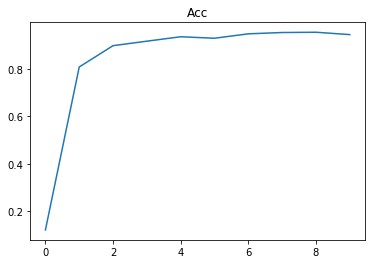

In [6]:
# 准确率增长图绘制
plt.figure()
plt.title('Acc')
plt.plot(range(num_epochs), acc)
plt.show()

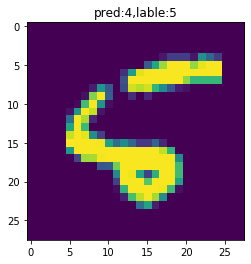

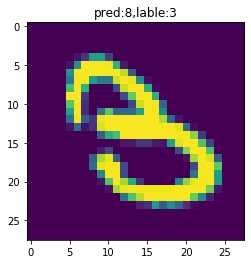

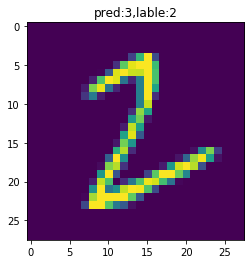

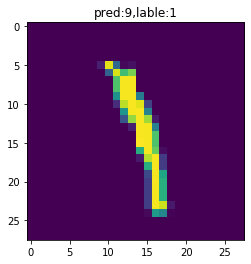

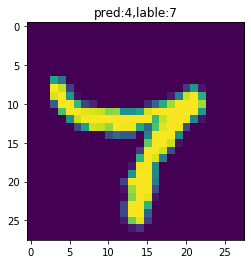

In [5]:
# 输出数据可视化
from PIL import Image

sample_n = 5
n = 0

for data in test_loader:
    img, label = data
    images = (img*256).int()
    if use_gpu:
        img = img.cuda()
        label = label.cuda()
    with torch.no_grad():
        out = model(img)
    _, pred = torch.max(out, 1)
    for i in range(len(pred)):
        if pred[i] != label[i]:
            plt.figure()
            plt.title('pred:{},lable:{}'.format(int(pred[i]), int(label[i])))
            plt.imshow(images[i][0])
            n += 1
        if(n >= sample_n):
            break
    if(n >= sample_n):
        break

### 实验结果分析
* 与全连接前馈神神经网络的结果相比较，从准确率上来看可以发现在卷积LeNet-5下准确率上升更快，在接近第7个epoch时就达到了0.94，而全连接网络则是在第16个epoch才到达0.94（在相同的学习率下）。
* 但是从可视化的结果来看，第3、4张图片的错误十分意外，这说明学习过程中可能出现了过拟合的现象。